In [143]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import os

raw_US = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv', 
                     index_col = 'date',
                     parse_dates = True).sort_index()
raw_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
                     index_col = 'date',
                     parse_dates = True).sort_index()

population = pd.read_html('https://simple.wikipedia.org/wiki/List_of_U.S._states_by_population')[0].set_index(['State'])
population = population["Population estimate, July 1, 2019[2]"]

pop_dict = dict(population)
pop_dict['Virgin Islands'] = pop_dict['U.S. Virgin Islands']

raw_states['cases per million'] = raw_states.apply(lambda row: 1000000*row.cases/pop_dict[row.state], axis = 1)
raw_states['deaths per million'] = raw_states.apply(lambda row: 1000000*row.deaths/pop_dict[row.state], axis = 1)

print(raw_US.head())
print(raw_states.head(), '\n')
print(population.head())

list_of_states = raw_states['state'].unique()
new_weekly_cases_state = {}
percent_weekly_cases = {}
change_in_new_cases = {}
new_cases_per_mil = {}

            cases  deaths
date                     
2020-01-21      1       0
2020-01-22      1       0
2020-01-23      1       0
2020-01-24      2       0
2020-01-25      3       0
                 state  fips  cases  deaths  cases per million  \
date                                                             
2020-01-21  Washington    53      1       0           0.131322   
2020-01-22  Washington    53      1       0           0.131322   
2020-01-23  Washington    53      1       0           0.131322   
2020-01-24    Illinois    17      1       0           0.078915   
2020-01-24  Washington    53      1       0           0.131322   

            deaths per million  
date                            
2020-01-21                 0.0  
2020-01-22                 0.0  
2020-01-23                 0.0  
2020-01-24                 0.0  
2020-01-24                 0.0   

State
California      39512223
Texas           28995881
Florida         21477737
New York        19453561
Pennsylvania    

['Arizona', 'Utah', 'Oregon', 'Michigan', 'Puerto Rico']
['Illinois', 'Massachusetts', 'Rhode Island', 'New Jersey', 'Delaware']


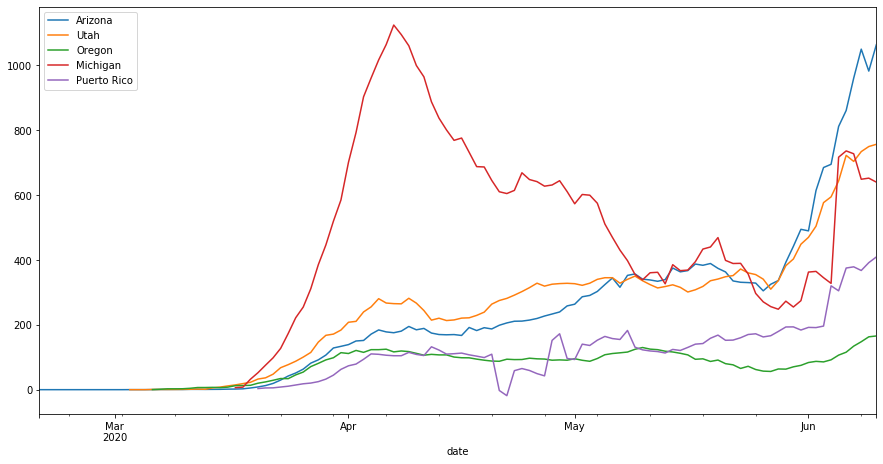

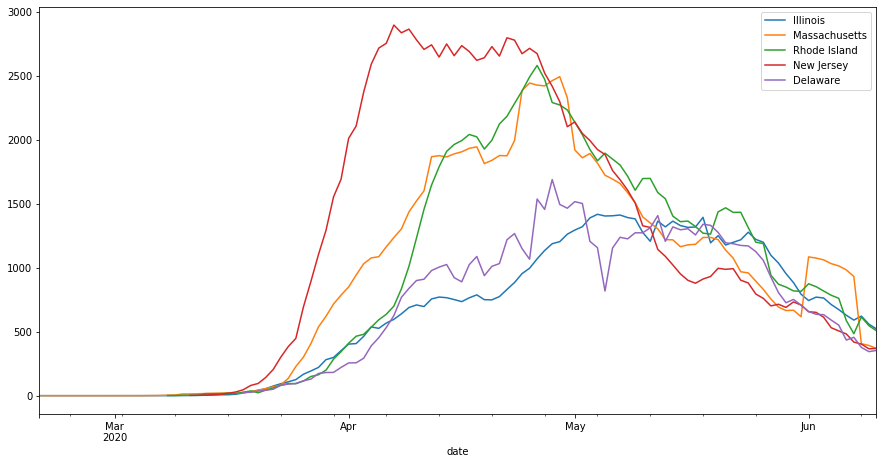

In [144]:
for state in list_of_states:
    if state in population:
        total_case = round(100*raw_states.loc[raw_states['state'] == state].cases[-1]/raw_US.cases[-1], 4)
        if total_case > 0.25:
            new_weekly_cases_state[state] = raw_states.loc[raw_states['state'] == state].cases.diff(7)
            new_cases_per_mil[state] = raw_states.loc[raw_states['state'] == state]['cases per million'].diff(7)
            percent_weekly_cases[state] = 100*raw_states.loc[raw_states['state'] == state].cases.diff(7)/raw_US.cases.diff(7)
            #change_in_new_cases[state] = 100*new_cases_per_mil[state].diff(14)[-1]/new_cases_per_mil[state][-15]
            change_in_new_cases[state] = 100*new_weekly_cases_state[state].diff(14)[-1]/new_weekly_cases_state[state][-15]


            
order = list(change_in_new_cases.values())
order.sort(reverse = True)
top_10_states = [key for key, value in change_in_new_cases.items() if value in order[:5] ]
bottom_states = [key for key, value in change_in_new_cases.items() if value in order[-5:]]
print(top_10_states)
print(bottom_states)
    
plt.figure(figsize = (15,7.5))
for st in top_10_states:
    new_cases_per_mil[st]['2020-02-20':].plot(label = st)
plt.legend()

plt.figure(figsize = (15,7.5))
for st in bottom_states:
    new_cases_per_mil[st]['2020-02-20':].plot(label = st)
plt.legend()


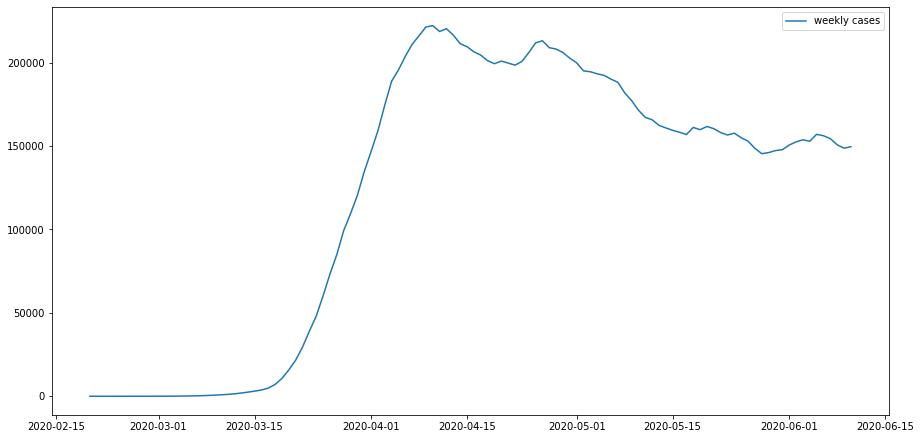

In [145]:
plt.figure(figsize = (15,7.5))
plt.plot(raw_US.cases.diff(7)[30:], label = "weekly cases" )
plt.legend()

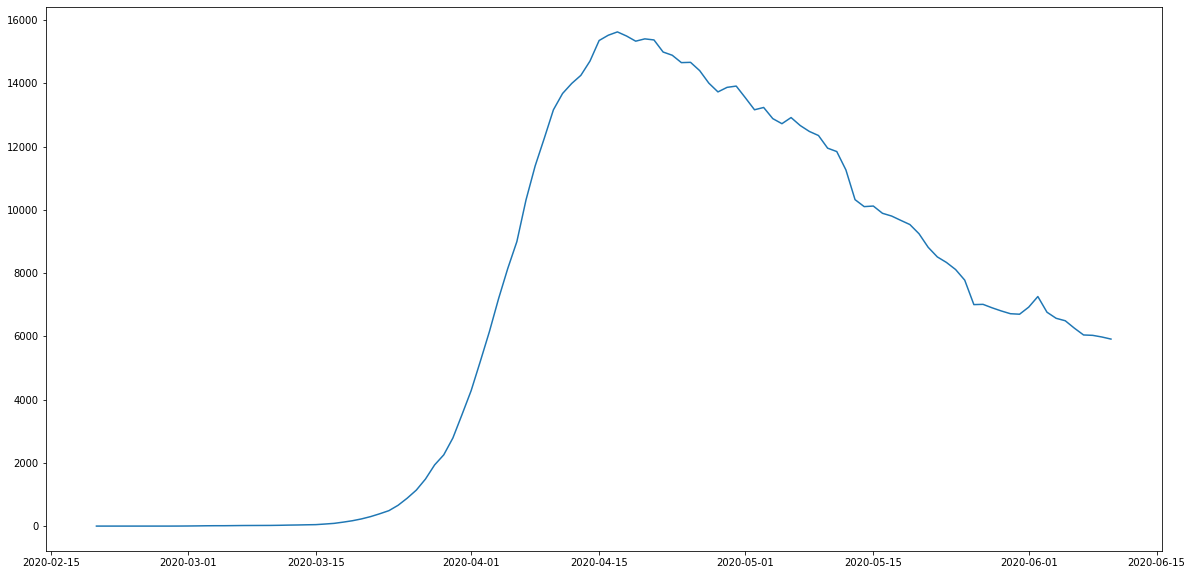

In [146]:
plt.figure(figsize = (20,10))
plt.plot(raw_US.deaths.diff(7)[30:], label = "weekly deaths")

In [147]:
###t = raw_US.index.to_list()[30:]
#data1 = raw_US.cases.diff(7).diff()[30:]
#data2 = raw_US.deaths.diff(7).diff()[30:]

###data1 = raw_US.cases.diff(7)[30:]
###data2 = raw_US.deaths.diff(7)[30:]


###fig, ax1 = plt.subplots( figsize=(20,15) )

###color = 'tab:red'
###ax1.set_xlabel('date')
###ax1.set_ylabel('Cases', color=color)
#ax1.set_ylabel('Cases')
###ax1.plot(t, data1, color=color)
#ax1.plot(t, data1)
#ax1.tick_params(axis='y', labelcolor=color)
###ax1.tick_params(axis='y')
###ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
#ax2.set_ylabel('Deaths', color=color)  # we already handled the x-label with ax1
###ax2.set_ylabel('Deaths')  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
###ax2.plot(t, data2)
#ax2.tick_params(axis='y', labelcolor=color)
###ax2.tick_params(axis='y')

###fig.tight_layout()  # otherwise the right y-label is slightly clipped
###plt.show()

<Figure size 1440x720 with 0 Axes>

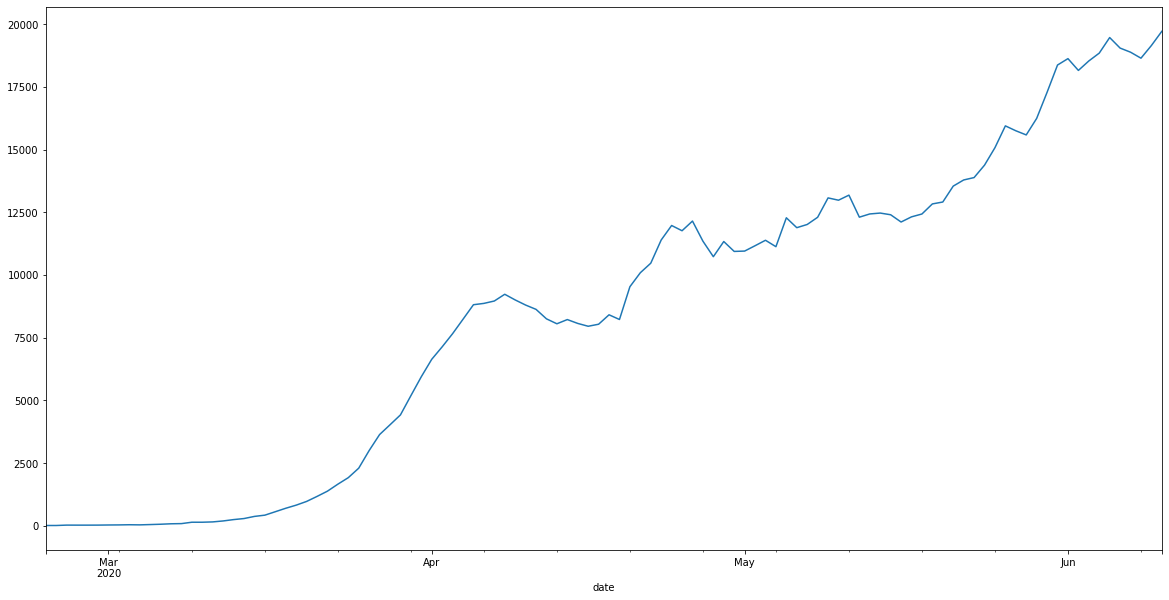

<Figure size 1440x720 with 0 Axes>

In [148]:
cal = raw_states.loc[raw_states['state'] == 'California'].cases
NY = raw_states.loc[raw_states['state'] == 'New York'].cases
NJ = raw_states.loc[raw_states['state'] == 'New Jersey'].cases
HI = raw_states.loc[raw_states['state'] == 'Hawaii'].cases
WA = raw_states.loc[raw_states['state'] == 'Washington'].cases
plt.figure(figsize = (20,10))
cal.diff(7)[30:].plot()
plt.figure(figsize = (20,10))

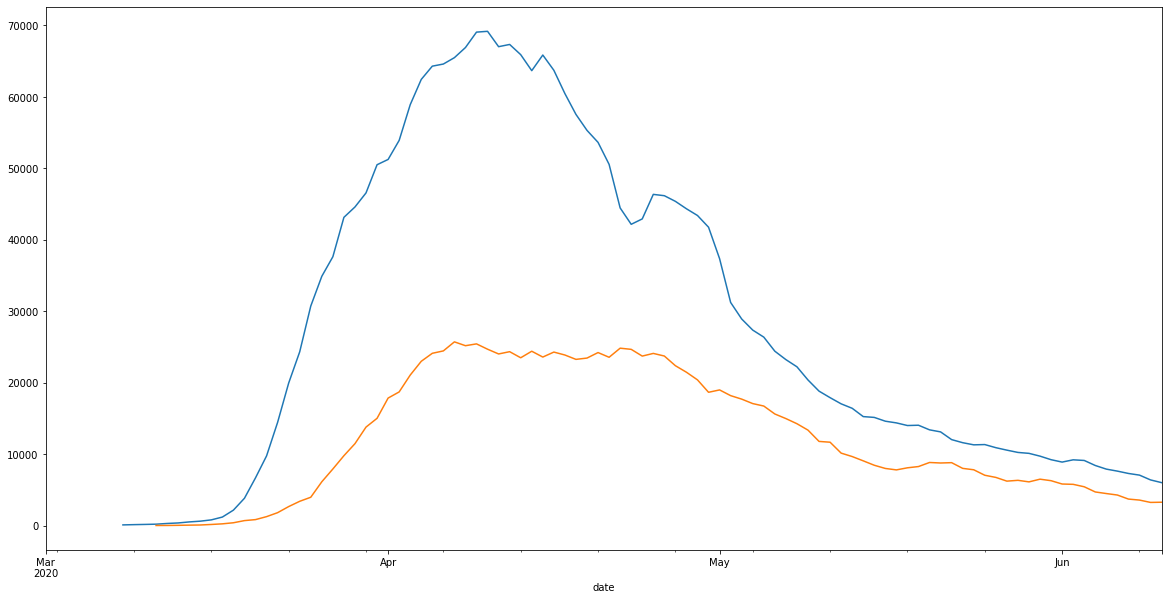

In [149]:
plt.figure(figsize = (20,10))
(NY.diff(7)[:]).plot()
NJ.diff(7)[:].plot()

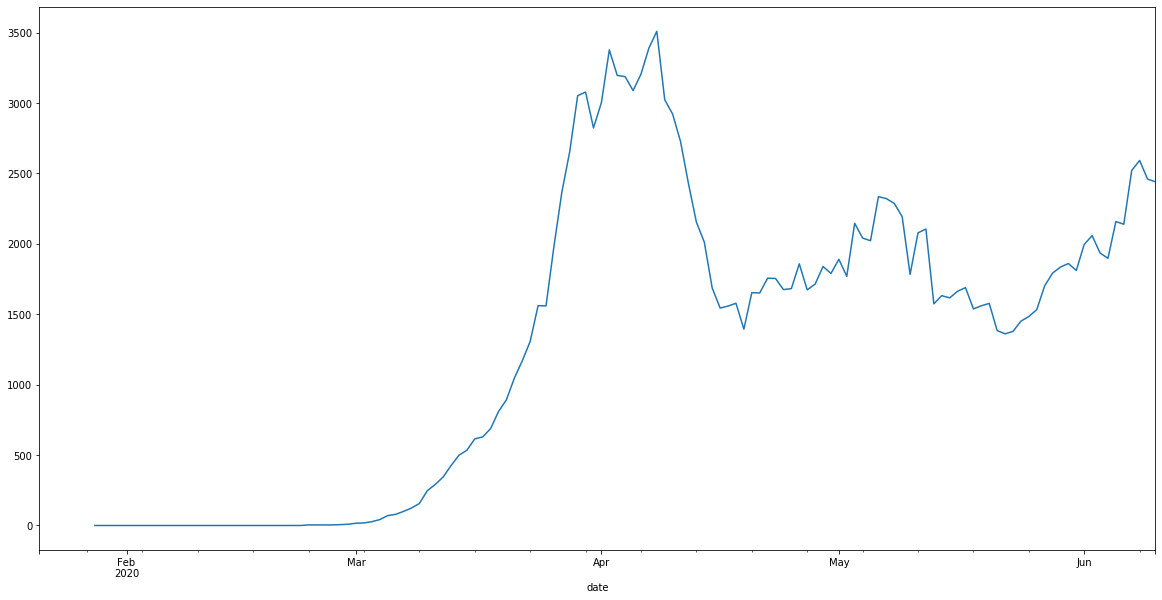

In [150]:
plt.figure(figsize = (20,10))
WA.diff(7).plot()

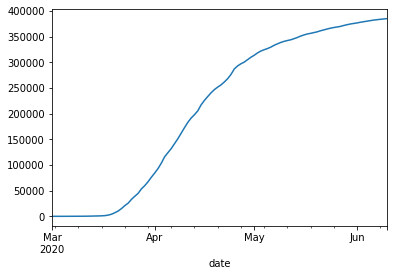

In [151]:
NY.plot()